## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [63]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from statistics import mean

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [64]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [65]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [66]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [67]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [68]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [69]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
         LeakyReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
         LeakyReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
        LeakyReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
       LogSoftmax-13                   [-1, 10]               0
Total params: 576,810
Trainable params:

Your experiments come here:

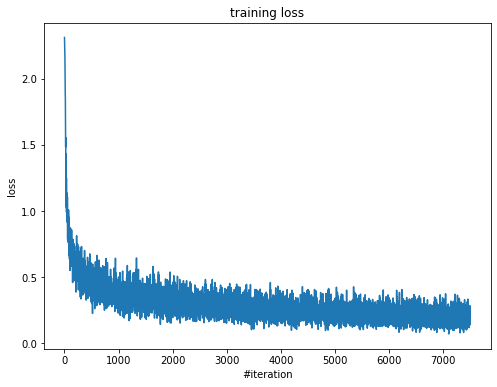

In [70]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epoch = 16
loss_history = []
loss_history_np = []

for epoch in range(n_epoch):
    for x_train, y_train in train_loader:
        opt.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        pred = model.forward(x_train)
        loss_value = loss_func(pred, y_train)
        loss_history.append(loss_value)
        loss_history_np.append(loss_value.detach().numpy())
        loss_value.backward()
        opt.step()
        
clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title('training loss')
plt.xlabel('#iteration')
plt.ylabel('loss')
plt.plot(loss_history_np)
plt.show()

In [71]:
def compute_accuracy_from_tensors(y_true_tensor, y_pred_tensor):
    y_true_numpy = y_true_tensor.cpu().detach().numpy()[:, None]
    encoder = OneHotEncoder()
    encoder.fit(np.arange(10)[:, None])
    y_pred_decoded = encoder.inverse_transform(y_pred_tensor.cpu().detach().numpy())
    return accuracy_score(y_true_numpy, y_pred_decoded)

def compute_average_accuracy(model):
    accuracy_list = []
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        test_pred = model.forward(x_test)
        accuracy_list.append(compute_accuracy_from_tensors(y_test, test_pred))
        
    print('accuracy score on all test data is: ', mean(accuracy_list))

compute_average_accuracy(model)

accuracy score on all test data is:  0.8927734375


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [72]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [73]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
         LeakyReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
         LeakyReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
        LeakyReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
       LogSoftmax-13                   [-1, 10]               0
Total params: 576,810
Trainable params:

In [74]:
fmnist_dataset_train_cut, _ = torch.utils.data.random_split(fmnist_dataset_train, [5000, 55000])

In [75]:
train_loader_cutted = torch.utils.data.DataLoader(fmnist_dataset_train_cut, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [76]:
for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    break

In [77]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

n_epoch = 64
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
train_loss_history_np = []
test_loss_history_np = []


for epoch in range(n_epoch):
    for x_train, y_train in train_loader_cutted:
        opt.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        #train
        train_pred = model.forward(x_train)
        train_loss_value = loss_func(train_pred, y_train)
        train_loss_history.append(train_loss_value)
        train_loss_history_np.append(train_loss_value.detach().numpy())
        train_accuracy_history.append(compute_accuracy_from_tensors(y_train, train_pred))
        train_loss_value.backward()
        opt.step()

        #test
        test_pred = model.forward(x_test)
        test_loss_value = loss_func(test_pred, y_test)                
        test_loss_history.append(test_loss_value)
        test_loss_history_np.append(test_loss_value.detach().numpy())
        test_accuracy_history.append(compute_accuracy_from_tensors(y_test, test_pred))

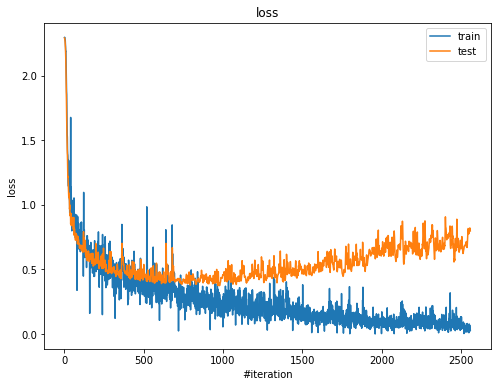

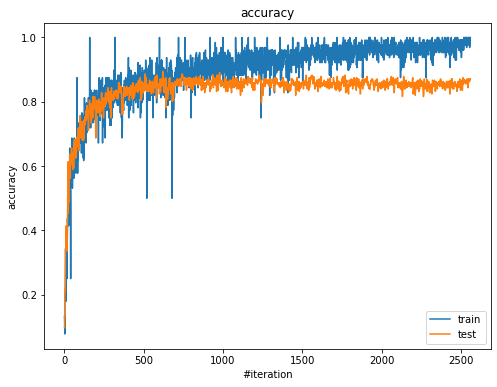

current train loss: 0.029337
current test loss: 0.797741
current train accuracy score:  1.0
current test accuracy score:  0.87109375
accuracy score on all test data is:  0.841796875


In [78]:
def plot(train_history, test_history, name):
    plt.figure(figsize=(8, 6))
    plt.title(name)
    plt.xlabel('#iteration')
    plt.ylabel(name)
    plt.plot(train_history, label='train')
    plt.plot(test_history, label='test')
    plt.legend()
    plt.show()

clear_output(wait=True)
plot(train_loss_history_np, test_loss_history_np, 'loss')
plot(train_accuracy_history, test_accuracy_history, 'accuracy')

print('current train loss: %f' % train_loss_value)
print('current test loss: %f' % test_loss_value)
print('current train accuracy score: ', train_accuracy_history[-1])
print('current test accuracy score: ', test_accuracy_history[-1])

compute_average_accuracy(model)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [79]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [80]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
         LeakyReLU-4                  [-1, 512]               0
       BatchNorm1d-5                  [-1, 512]           1,024
            Linear-6                  [-1, 256]         131,328
         LeakyReLU-7                  [-1, 256]               0
       BatchNorm1d-8                  [-1, 256]             512
            Linear-9                  [-1, 128]          32,896
          Dropout-10                  [-1, 128]               0
        LeakyReLU-11                  [-1, 128]               0
      BatchNorm1d-12                  [-1, 128]             256
           Linear-13                   [-1, 64]           8,256
      BatchNorm1d-14                   

In [81]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

n_epoch = 64
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
train_loss_history_np = []
test_loss_history_np = []


for epoch in range(n_epoch):
    for x_train, y_train in train_loader_cutted:
        opt.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        #train
        train_pred = model.forward(x_train)
        train_loss_value = loss_func(train_pred, y_train)
        train_loss_history.append(train_loss_value)
        train_loss_history_np.append(train_loss_value.detach().numpy())
        train_accuracy_history.append(compute_accuracy_from_tensors(y_train, train_pred))
        train_loss_value.backward()
        opt.step()

        #test
        test_pred = model.forward(x_test)
        test_loss_value = loss_func(test_pred, y_test)                
        test_loss_history.append(test_loss_value)
        test_loss_history_np.append(test_loss_value.detach().numpy())
        test_accuracy_history.append(compute_accuracy_from_tensors(y_test, test_pred))

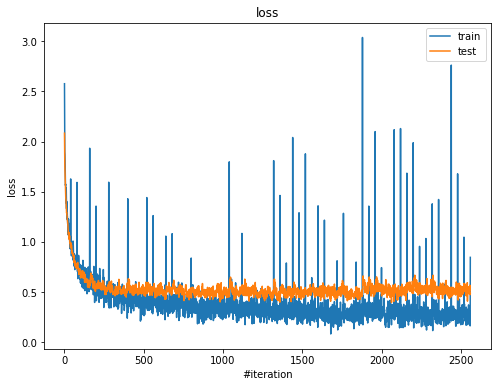

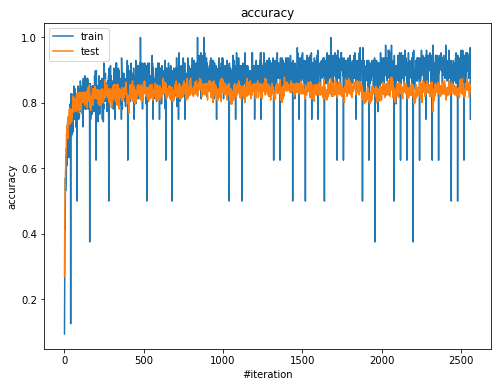

current train loss: 0.845161
current test loss: 0.484892
current train accuracy score:  0.75
current test accuracy score:  0.84765625
accuracy score on all test data is:  0.83408203125


In [82]:
clear_output(wait=True)
plot(train_loss_history_np, test_loss_history_np, 'loss')
plot(train_accuracy_history, test_accuracy_history, 'accuracy')

print('current train loss: %f' % train_loss_value)
print('current test loss: %f' % test_loss_value)
print('current train accuracy score: ', train_accuracy_history[-1])
print('current test accuracy score: ', test_accuracy_history[-1])

compute_average_accuracy(model)

### Conclusions:
_Write down small report with your conclusions and your ideas._

Based on the experiments, we can conclude that in order to combat retraining, Butchnorm and Dropout are really effective. If we apply dropout and batchnorm together, this is even more noticeable.